## NYC crimes Part2

In [2]:
# Load libraries
import numpy as np 
import pandas as pd 
from subprocess import check_output
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline 
import matplotlib
matplotlib.style.use('ggplot')

In [4]:
import glob, re
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor

In [5]:
np.random.seed(10)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### 1.1. Data import and aggregation

In [5]:
# Data Aggregation
Data = pd.read_csv('Data.csv')

In [6]:
Data.head()

,Unnamed: 0,CMPLNT_NUM,ADDR_PCT_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,...,Latitude,Longitude,Lat_Lon,PATROL_BORO,Crime_date,month,day,dw,dy,year
0,5268,479939731,83.0,"BURGLARY,RESIDENCE,DAY",COMPLETED,FELONY,BROOKLYN,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,...,40.694791,-73.926244,"(40.694790591, -73.926244422)",PATROL BORO BKLYN NORTH,2018-03-31,3,31,5,90,2018
1,5269,363411847,77.0,"BURGLARY,RESIDENCE,NIGHT",COMPLETED,FELONY,BROOKLYN,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,...,40.672261,-73.965030,"(40.672260603, -73.965029797)",PATROL BORO BKLYN NORTH,2018-03-31,3,31,5,90,2018
2,5271,206569444,77.0,"BURGLARY,RESIDENCE,DAY",COMPLETED,FELONY,BROOKLYN,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,...,40.672261,-73.965030,"(40.672260603, -73.965029797)",PATROL BORO BKLYN NORTH,2018-03-31,3,31,5,90,2018
3,5272,656107443,115.0,"BURGLARY,RESIDENCE,NIGHT",COMPLETED,FELONY,QUEENS,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,...,40.751867,-73.893221,"(40.751866686, -73.893221445)",PATROL BORO QUEENS NORTH,2018-03-31,3,31,5,90,2018
4,5273,622935108,25.0,"BURGLARY,RESIDENCE,DAY",COMPLETED,FELONY,MANHATTAN,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,...,40.798160,-73.938403,"(40.798159532, -73.938402699)",PATROL BORO MAN NORTH,2018-03-31,3,31,5,90,2018


In [7]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155037 entries, 0 to 155036
Data columns (total 21 columns):
Unnamed: 0           155037 non-null int64
CMPLNT_NUM           155037 non-null int64
ADDR_PCT_CD          155014 non-null float64
PD_DESC              155037 non-null object
CRM_ATPT_CPTD_CD     155037 non-null object
LAW_CAT_CD           155037 non-null object
BORO_NM              154900 non-null object
LOC_OF_OCCUR_DESC    154435 non-null object
PREM_TYP_DESC        154748 non-null object
JURIS_DESC           155037 non-null object
JURISDICTION_CODE    155037 non-null int64
Latitude             154554 non-null float64
Longitude            154554 non-null float64
Lat_Lon              154554 non-null object
PATROL_BORO          155013 non-null object
Crime_date           155037 non-null object
month                155037 non-null int64
day                  155037 non-null int64
dw                   155037 non-null int64
dy                   155037 non-null int64
year         

In [8]:
Data.ADDR_PCT_CD.unique()

array([ 83.,  77., 115.,  25.,  42.,   5.,  52.,  79., 102.,  44.,  19.,
        69.,   6., 113.,  94., 105.,  48.,  62.,  61.,  17.,  73.,  32.,
        34.,  43.,   1., 107., 122.,  71.,  67.,  33.,  10., 109.,  60.,
        47., 114.,  28., 120.,  46.,  41.,   9.,  75.,  68.,  24.,  76.,
       110.,  50., 101., 106., 111.,   7.,  30., 108.,  49.,  84.,  63.,
        81.,  45., 121., 104.,  70.,  78.,  20.,  23., 100.,  90., 103.,
        40.,  14.,  66.,  72., 112., 123.,  26.,  18.,  13.,  88.,  22.,
        nan])

In [9]:
Data.BORO_NM.unique()

array(['BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND', nan],
      dtype=object)

In [10]:
Data.PATROL_BORO.unique()

array(['PATROL BORO BKLYN NORTH', 'PATROL BORO QUEENS NORTH',
       'PATROL BORO MAN NORTH', 'PATROL BORO BRONX',
       'PATROL BORO MAN SOUTH', 'PATROL BORO QUEENS SOUTH',
       'PATROL BORO BKLYN SOUTH', 'PATROL BORO STATEN ISLAND', nan],
      dtype=object)

In [11]:
Data.describe()

,Unnamed: 0,CMPLNT_NUM,ADDR_PCT_CD,JURISDICTION_CODE,Latitude,Longitude,month,day,dw,dy,year
count,155037.000000,1.550370e+05,155014.000000,155037.000000,154554.000000,154554.000000,155037.000000,155037.000000,155037.000000,155037.000000,155037.000000
mean,82835.272200,5.496751e+08,73.026656,0.204635,40.724914,-73.910675,6.665273,15.779169,2.761141,187.519928,2010.905461
std,44756.626726,2.596783e+08,31.355621,3.368495,0.083519,0.080135,3.460495,8.808529,1.942554,105.811564,3.361665
min,5268.000000,1.000054e+08,1.000000,0.000000,40.498905,-74.254560,1.000000,1.000000,0.000000,1.000000,2006.000000
25%,44076.000000,3.244054e+08,48.000000,0.000000,40.666535,-73.955829,4.000000,8.000000,1.000000,96.000000,2008.000000
50%,82836.000000,5.503841e+08,73.000000,0.000000,40.710179,-73.916407,7.000000,16.000000,3.000000,193.000000,2011.000000
75%,121595.000000,7.743717e+08,104.000000,0.000000,40.786895,-73.864993,10.000000,23.000000,4.000000,278.000000,2014.000000
max,160413.000000,9.999640e+08,123.000000,97.000000,40.912723,-73.700720,12.000000,31.000000,6.000000,366.000000,2018.000000


In [12]:
Data = Data.drop(['Unnamed: 0' , 'CMPLNT_NUM','LAW_CAT_CD'], axis=1)

In [13]:
Data = Data.drop(['JURISDICTION_CODE' , 'Lat_Lon'], axis=1)

In [14]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155037 entries, 0 to 155036
Data columns (total 16 columns):
ADDR_PCT_CD          155014 non-null float64
PD_DESC              155037 non-null object
CRM_ATPT_CPTD_CD     155037 non-null object
BORO_NM              154900 non-null object
LOC_OF_OCCUR_DESC    154435 non-null object
PREM_TYP_DESC        154748 non-null object
JURIS_DESC           155037 non-null object
Latitude             154554 non-null float64
Longitude            154554 non-null float64
PATROL_BORO          155013 non-null object
Crime_date           155037 non-null object
month                155037 non-null int64
day                  155037 non-null int64
dw                   155037 non-null int64
dy                   155037 non-null int64
year                 155037 non-null int64
dtypes: float64(3), int64(5), object(8)
memory usage: 18.9+ MB


In [131]:
Data['Crime_date'] = pd.to_datetime(Data['Crime_date'])

In [15]:
df = pd.DataFrame(Data)

### 1.2. Data aggregation

In [16]:
Group_date = df.groupby(['Crime_date','ADDR_PCT_CD','BORO_NM','PATROL_BORO'], as_index=False)['PD_DESC'].count().rename(
    columns={'PD_DESC': 'Burglary_count'})
Group_date.head()

,Crime_date,ADDR_PCT_CD,BORO_NM,PATROL_BORO,Burglary_count
0,2006-01-01,7.0,MANHATTAN,PATROL BORO MAN SOUTH,1
1,2006-01-01,9.0,MANHATTAN,PATROL BORO MAN SOUTH,1
2,2006-01-01,19.0,MANHATTAN,PATROL BORO MAN NORTH,1
3,2006-01-01,28.0,MANHATTAN,PATROL BORO MAN NORTH,1
4,2006-01-01,43.0,BRONX,PATROL BORO BRONX,1


In [17]:
Group_date2 = df.groupby(['Crime_date','ADDR_PCT_CD','BORO_NM','PATROL_BORO'], as_index=False)['Latitude','Longitude'].mean().rename(
    columns={'PD_DESC': 'Burglary_count'})
Group_date2.head()

,Crime_date,ADDR_PCT_CD,BORO_NM,PATROL_BORO,Latitude,Longitude
0,2006-01-01,7.0,MANHATTAN,PATROL BORO MAN SOUTH,40.717847,-73.985359
1,2006-01-01,9.0,MANHATTAN,PATROL BORO MAN SOUTH,40.729883,-73.985187
2,2006-01-01,19.0,MANHATTAN,PATROL BORO MAN NORTH,40.775290,-73.956567
3,2006-01-01,28.0,MANHATTAN,PATROL BORO MAN NORTH,40.803932,-73.950140
4,2006-01-01,43.0,BRONX,PATROL BORO BRONX,40.827860,-73.874180


In [18]:
data_grup = pd.merge(Group_date,Group_date2, how='left',on=['Crime_date','ADDR_PCT_CD','BORO_NM','PATROL_BORO'])
data_grup.head()

,Crime_date,ADDR_PCT_CD,BORO_NM,PATROL_BORO,Burglary_count,Latitude,Longitude
0,2006-01-01,7.0,MANHATTAN,PATROL BORO MAN SOUTH,1,40.717847,-73.985359
1,2006-01-01,9.0,MANHATTAN,PATROL BORO MAN SOUTH,1,40.729883,-73.985187
2,2006-01-01,19.0,MANHATTAN,PATROL BORO MAN NORTH,1,40.775290,-73.956567
3,2006-01-01,28.0,MANHATTAN,PATROL BORO MAN NORTH,1,40.803932,-73.950140
4,2006-01-01,43.0,BRONX,PATROL BORO BRONX,1,40.827860,-73.874180


In [19]:
import copy

In [20]:
data =copy.copy(data_grup)

In [21]:
data.Burglary_count.min(),data.Burglary_count.max()

(1, 12)

In [22]:
data.Crime_date.min(),data.Crime_date.max()

('2006-01-01', '2018-03-31')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Number of home burglaries')

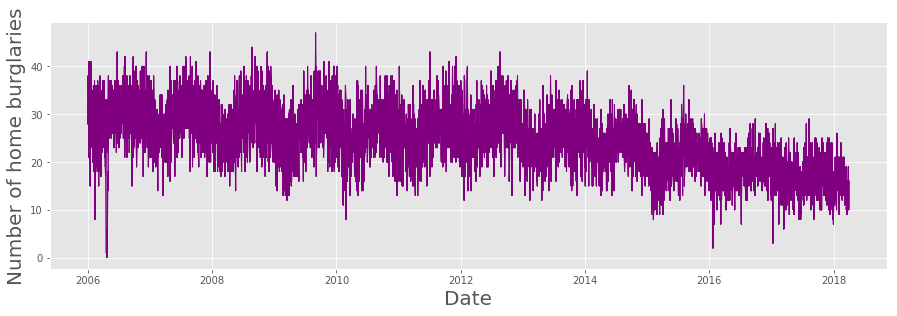

In [30]:
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(211)
temp = data.groupby(['Crime_date']).count()
ax1.plot(temp,'purple',linewidth=1)
ax1.set_xlabel('Date',fontsize=20)
ax1.set_ylabel('Number of home burglaries',fontsize=20)

In [31]:
data['month'] = data['Crime_date'].dt.month 
data['day'] = data['Crime_date'].dt.day
data['dw'] = data['Crime_date'].dt.dayofweek
data['dy'] = data['Crime_date'].dt.dayofyear
data['year'] = data['Crime_date'].dt.year

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


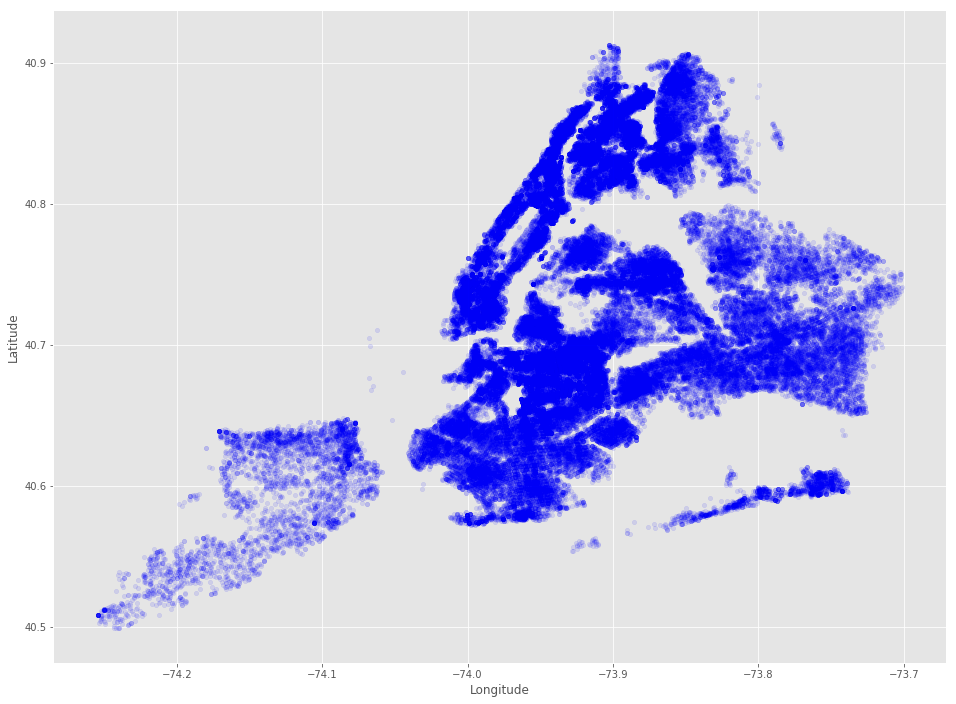

In [32]:
# Quick plot for data check
data.plot(kind = 'scatter', x = 'Longitude', y = 'Latitude', marker = 'o', alpha = 0.1,figsize = (16,12),colors='blue');

In [179]:
Data = Data.replace(np.nan, 0)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111300 entries, 0 to 111299
Data columns (total 12 columns):
Crime_date        111300 non-null datetime64[ns]
ADDR_PCT_CD       111300 non-null float64
BORO_NM           111300 non-null object
PATROL_BORO       111300 non-null object
Burglary_count    111300 non-null int64
Latitude          110993 non-null float64
Longitude         110993 non-null float64
month             111300 non-null int64
day               111300 non-null int64
dw                111300 non-null int64
dy                111300 non-null int64
year              111300 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(6), object(2)
memory usage: 11.0+ MB


### 1.3  One Hat Encoding

In [35]:
def our_hat_code(myData, colQuery):
    temp = list(myData[colQuery].unique())
    print(temp)
    n = len(temp) 
    print(n)
    for ii in range(0,n):
        myData[temp[ii]] = None
        myData.loc[(myData[colQuery] == temp[ii] ),temp[ii]] = 1
        myData.loc[(myData[colQuery] != temp[ii]),temp[ii]] = 0


In [36]:
# One Hat Encoding for Device
data['BORO_NM'] = data['BORO_NM'].astype('category')
our_hat_code(data,'BORO_NM')

['MANHATTAN', 'BRONX', 'BROOKLYN', 'QUEENS', 'STATEN ISLAND']
5


In [37]:
# One Hat Encoding for Device
data['PATROL_BORO'] = data['PATROL_BORO'].astype('category')
our_hat_code(data,'PATROL_BORO')

['PATROL BORO MAN SOUTH', 'PATROL BORO MAN NORTH', 'PATROL BORO BRONX', 'PATROL BORO BKLYN SOUTH', 'PATROL BORO BKLYN NORTH', 'PATROL BORO QUEENS SOUTH', 'PATROL BORO QUEENS NORTH', 'PATROL BORO STATEN ISLAND']
8


In [38]:
# One Hat Encoding for Device
data['month'] = data['month'].astype('category')
our_hat_code(data,'month')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
12


In [39]:
# One Hat Encoding for Device
data['dw'] = data['dw'].astype('category')
our_hat_code(data,'dw')

[6, 0, 1, 2, 3, 4, 5]
7


In [40]:
# One Hat Encoding for Device
data['year'] = data['year'].astype('category')
our_hat_code(data,'year')

[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
13


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111300 entries, 0 to 111299
Data columns (total 51 columns):
Crime_date                   111300 non-null datetime64[ns]
ADDR_PCT_CD                  111300 non-null float64
BORO_NM                      111300 non-null category
PATROL_BORO                  111300 non-null category
Burglary_count               111300 non-null int64
Latitude                     110993 non-null float64
Longitude                    110993 non-null float64
month                        111300 non-null category
day                          111300 non-null int64
dw                           111300 non-null category
dy                           111300 non-null int64
year                         111300 non-null category
MANHATTAN                    111300 non-null int64
BRONX                        111300 non-null int64
BROOKLYN                     111300 non-null int64
QUEENS                       111300 non-null int64
STATEN ISLAND                111300 non-nul

In [60]:
data.to_csv(r'C:\Users\Katy\Downloads\Home_Task_Localize\data_1_hot.csv')

## 2. Forecast and model selection

### 2.1 Train test partition

In [29]:
# Data Aggregation
Data = pd.read_csv('data_1_hot.csv')

In [30]:
Data.head()

,Unnamed: 0,Crime_date,ADDR_PCT_CD,BORO_NM,PATROL_BORO,Burglary_count,Latitude,Longitude,month,day,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,0,2006-01-01,7.0,MANHATTAN,PATROL BORO MAN SOUTH,1,40.717847,-73.985359,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,2006-01-01,9.0,MANHATTAN,PATROL BORO MAN SOUTH,1,40.729883,-73.985187,1,1,...,0,0,0,0,0,0,0,0,0,0
2,2,2006-01-01,19.0,MANHATTAN,PATROL BORO MAN NORTH,1,40.775290,-73.956567,1,1,...,0,0,0,0,0,0,0,0,0,0
3,3,2006-01-01,28.0,MANHATTAN,PATROL BORO MAN NORTH,1,40.803932,-73.950140,1,1,...,0,0,0,0,0,0,0,0,0,0
4,4,2006-01-01,43.0,BRONX,PATROL BORO BRONX,1,40.827860,-73.874180,1,1,...,0,0,0,0,0,0,0,0,0,0


In [31]:
Data['date'] = pd.to_datetime(Data['Crime_date'],  format='%Y/%m/%d')

In [32]:
Data = Data.drop(['Unnamed: 0'], axis=1)

In [33]:
Data = Data.replace(np.nan, 0)

In [34]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111300 entries, 0 to 111299
Data columns (total 52 columns):
Crime_date                   111300 non-null object
ADDR_PCT_CD                  111300 non-null float64
BORO_NM                      111300 non-null object
PATROL_BORO                  111300 non-null object
Burglary_count               111300 non-null int64
Latitude                     111300 non-null float64
Longitude                    111300 non-null float64
month                        111300 non-null int64
day                          111300 non-null int64
dw                           111300 non-null int64
dy                           111300 non-null int64
year                         111300 non-null object
MANHATTAN                    111300 non-null int64
BRONX                        111300 non-null int64
BROOKLYN                     111300 non-null int64
QUEENS                       111300 non-null int64
STATEN ISLAND                111300 non-null int64
PATROL BORO 

In [35]:
del Data['Crime_date']

In [36]:
col = [c for c in Data if c not in ['BORO_NM','PATROL_BORO','month','dw','year','Crime_date']]

In [37]:
X=Data[col]
X_train = Data[Data.date <'2018-01-01'][col]
X_test = Data[Data.date >='2018-01-01'][col]

y_train =Data[Data.date <'2018-01-01']['Burglary_count'].values
y_test = Data[Data.date >='2018-01-01']['Burglary_count'].values

In [38]:
import time

In [39]:
X_train['date']= list(map(lambda x: time.mktime(x.timetuple()),X_train['date']))

In [40]:
X_test['date']=list(map(lambda x: time.mktime(x.timetuple()),X_test['date']))

### 2.2 Model selection

In [41]:
def MSE(y, pred):
    return metrics.mean_squared_error(y, pred)

In [42]:
#nan_rows = data_y[data_y.isnull().T.any().T]

In [43]:
col_sab = ['date','ADDR_PCT_CD','Burglary_count']

In [44]:
test_sab =Data[Data.date >='2018-01-01'][col_sab]
test_sab.head()

,date,ADDR_PCT_CD,Burglary_count
109888,2018-01-01,7.0,1
109889,2018-01-01,28.0,2
109890,2018-01-01,32.0,1
109891,2018-01-01,43.0,1
109892,2018-01-01,44.0,2


In [45]:
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, 
                      max_depth =10)

In [46]:
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)

In [47]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
model3 = RandomForestRegressor(max_depth=2, random_state=0)

In [49]:
model4 = ensemble.ExtraTreesRegressor(n_estimators=225, max_depth=5, n_jobs=-1, random_state=3)

In [50]:
model1.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=3, subsample=0.8, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [51]:
model2.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
          weights='uniform')

In [53]:
model3.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [54]:
model4.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=5,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=225, n_jobs=-1,
          oob_score=False, random_state=3, verbose=0, warm_start=False)

In [55]:
preds1 = model1.predict(X_test)

In [56]:
preds2 = model2.predict(X_test)

In [57]:
preds3 = model3.predict(X_test)

In [58]:
preds4 = model4.predict(X_test)

In [59]:
def MSE(y, pred):
    return metrics.mean_squared_error(y, pred)

In [60]:
print('MSE GradientBoostingRegressor: ', MSE(y_test, preds1))

MSE GradientBoostingRegressor:  4.45831572147222e-08


In [61]:
print('MSE KNeighborsRegressor: ', MSE(y_test, preds2))

MSE KNeighborsRegressor:  0.3211756373937677


In [62]:
print('MSE RandomForestRegressor: ', MSE(y_test, preds3))

MSE RandomForestRegressor:  0.0044318468865460125


In [63]:
print('RMSE ExtraTreesRegressor: ', MSE(y_test, preds4))

RMSE ExtraTreesRegressor:  0.0005492867218953993


### 2.3 Import solutions with the best model

In [67]:
test_sab['predict'] = model1.predict(X_test)

In [69]:
test_sab.head()

,date,ADDR_PCT_CD,Burglary_count,predict
109888,2018-01-01,7.0,1,1.000160
109889,2018-01-01,28.0,2,1.999754
109890,2018-01-01,32.0,1,1.000160
109891,2018-01-01,43.0,1,1.000160
109892,2018-01-01,44.0,2,1.999754


In [70]:
test_sab.shape

(1412, 4)

In [72]:
Submission =test_sab[test_sab.ADDR_PCT_CD == 44]
Submission.head()

,date,ADDR_PCT_CD,Burglary_count,predict
109892,2018-01-01,44.0,2,1.999754
109907,2018-01-02,44.0,1,1.000160
109984,2018-01-08,44.0,1,1.000160
110054,2018-01-12,44.0,1,1.000160
110087,2018-01-14,44.0,1,1.000160


In [78]:
import copy
Submission1 = copy.copy(Submission)

In [80]:
Submission1.predict.sum(),Submission1.Burglary_count.sum()

(47.00242491416444, 47)

In [80]:
Submission1.predict.sum(),Submission1.Burglary_count.sum()

(47.00242491416444, 47)

In [74]:
Submission.describe().round(2)

,ADDR_PCT_CD,Burglary_count,predict
count,38.0,38.00,38.00
mean,44.0,1.24,1.24
std,0.0,0.54,0.54
min,44.0,1.00,1.00
25%,44.0,1.00,1.00
50%,44.0,1.00,1.00
75%,44.0,1.00,1.00
max,44.0,3.00,3.00


In [287]:
print(metrics.mean_squared_error(Submission['Burglary_count'], Submission['predict']))

5.1135420306298717e-08


In [81]:
Submission1.to_csv(r'C:\Users\Katy\Downloads\Home_Task_Localize\Submission1.csv')